In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [242]:
from __future__ import print_function, division

from matplotlib import pyplot as plt
import pandas
import src
import gensim
import os
import os.path
import csv
import functools
import itertools
import collections
import scipy
import scipy.stats
from operator import itemgetter
from pprint import pprint

def fake(*args, **kwargs):
    print('Fake called with', str(args), str(kwargs))
    sys.exit(1)

# fake out the create_model so we don't accidentally attempt to create data
src.common.create_model = fake

In [243]:
print(os.getcwd())
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
print(os.getcwd())

/home/cscorley/git/triage
/home/cscorley/git/triage


In [244]:
default_model_config, model_config_string = src.main.get_default_model_config(kwargs)
default_changeset_config, changeset_config_string = src.main.get_default_changeset_config()

model_config = dict(default_model_config)

model_config.update({
    'alpha_base': 1,
    'eta_base': 1,
})

changeset_config = dict(default_changeset_config)

def get_config_string(config):
    return '-'.join([unicode(v) for k, v in sorted(config.items()) if not k.endswith("_base")])

alpha_bases = ['auto', 1, 2, 5]
eta_bases = ['auto', 1, 2, 5]
num_topics = [100, 200, 500]

def get_rank_name(kind, experiment, changeset_config, model_config):
    """
    kind = [changeset, release, temporal]
    experiment = [triage, feature_location]
    """
    cs_str = get_config_string(changeset_config)
    model_config = dict(model_config)
    m_str = get_config_string(model_config)
    return '-'.join([kind, experiment, 'lda', cs_str, m_str, 'file', 'ranks']).lower() + '.csv.gz'

model_sweep = list()
for a, e, K in itertools.product(alpha_bases, eta_bases, num_topics):
    m = dict(model_config)
    m['alpha_base'] = a
    m['eta_base'] = e

    if a != 'auto':
        a /= K
    if e != 'auto':
        e /= K
    m['alpha'] = a
    m['eta'] = e
    m['num_topics'] = K
    model_sweep.append(m)

corpus_sweep = list()
b = [True, False]
for a, c, m, r in itertools.product(b, repeat=4):
    conf = dict(changeset_config)
    conf['include_additions'] = a
    conf['include_context'] = c
    conf['include_message'] = m
    conf['include_removals'] = r
    if any(conf.values()):
        corpus_sweep.append(conf)

In [245]:
kwargs = dict(model="lda", level="file", source=["changeset"], force=False, rankpath='', config=dict())

# All of the sweep files need renaming throughout.  The *do* use the seed, it's just not named correctly
model_config_string = model_config_string.replace("seed1-", "")

kwargs.update({'changeset_config': changeset_config,
               'changeset_config_string': changeset_config_string})

kwargs.update({'model_config': model_config,
               'model_config_string': model_config_string})

# load project info
projects = src.common.load_projects(kwargs)

#projects = src.common.load_projects(dict(model="lda", level="file", rankpath='', config=dict()), "../data")
projects

[Project(name='tika', printable_name='Tika v1.8', version='v1.8', ref='refs/tags/1.8', data_path='data/tika/', full_path='data/tika/v1.8/', src_path='data/tika/v1.8/src/', model_config={'passes': 1, 'num_topics': 500, 'algorithm': 'batch', 'decay': 0.5, 'eta_base': 1, 'alpha_base': 1, 'eta': 0.002, 'iterations': 1000, 'offset': 1.0, 'alpha': 0.002, 'max_bound_iterations': 1000}, source=['changeset'], model_config_string=u'batch-0.002-0.5-0.002-1000-1000-500-1.0-1', force=False, level='file', changeset_config_string=u'True-True-False-True', model='lda', config={}, changeset_config={'include_removals': True, 'include_message': False, 'include_additions': True, 'include_context': True}, rankpath=''),
 Project(name='pig', printable_name='Pig v0.14.0', version='v0.14.0', ref='refs/tags/release-0.14.0', data_path='data/pig/', full_path='data/pig/v0.14.0/', src_path='data/pig/v0.14.0/src/', model_config={'passes': 1, 'num_topics': 500, 'algorithm': 'batch', 'decay': 0.5, 'eta_base': 1, 'alpha

In [246]:
cs_dit = list()
for project, rankstuff in itertools.product(projects, [
        (c, get_rank_name('changeset', 'triage', c, model_config)) for c in corpus_sweep]):
    config, rankname = rankstuff
    rankpath = os.path.join(project.data_path, project.version, rankname)
    if os.path.exists(rankpath):
        #  cs_dit.append(project._replace(rankpath=rankpath, config=config))
        project = project._replace(changeset_config=config, rankpath=rankpath, config=config)
        cs_dit.append(
            project._replace(
                model_config_string=get_config_string(project.model_config),
                changeset_config_string=get_config_string(project.changeset_config)
            ))
    else:
        print(rankpath)

cs_flt = list()
for project, rankstuff in itertools.product(projects, [
        (c, get_rank_name('changeset', 'feature_location', c, model_config)) for c in corpus_sweep]):
    config, rankname = rankstuff
    rankpath = os.path.join(project.data_path, project.version,  rankname)
    if os.path.exists(rankpath):
        #cs_flt.append(project._replace(rankpath=rankpath, config=config))
        project = project._replace(changeset_config=config, rankpath=rankpath, config=config)
        cs_flt.append(
            project._replace(
                model_config_string=get_config_string(project.model_config),
                changeset_config_string=get_config_string(project.changeset_config)
            ))
    else:
        print(rankpath)

        
ms_dit = list()
for project, rankstuff in itertools.product(projects, [
        (c, get_rank_name('changeset', 'triage', changeset_config, c)) for c in model_sweep]):
    config, rankname = rankstuff
    rankpath = os.path.join(project.data_path, project.version,  rankname)
    if os.path.exists(rankpath):
        #ms_dit.append(project._replace(rankpath=rankpath, config=config))
        project = project._replace(model_config=config, rankpath=rankpath, config=config)
        ms_dit.append(
            project._replace(
                model_config_string=get_config_string(project.model_config),
                changeset_config_string=get_config_string(project.changeset_config)
            ))
    else:
        print(rankpath)
        
ms_flt = list()
for project, rankstuff in itertools.product(projects, [
        (c, get_rank_name('changeset', 'feature_location', changeset_config, c)) for c in model_sweep]):
    config, rankname = rankstuff
    rankpath = os.path.join(project.data_path, project.version,  rankname)
    if os.path.exists(rankpath):
        #ms_flt.append(project._replace(rankpath=rankpath, config=config))
        project = project._replace(model_config=config, rankpath=rankpath, config=config)
        ms_flt.append(
            project._replace(
                model_config_string=get_config_string(project.model_config),
                changeset_config_string=get_config_string(project.changeset_config)
            ))
    else:
        print(rankpath)

In [247]:
cs_dit[0]
src.triage.run_experiment(cs_dit[0])

{'changeset': [(4, '1269', u'Nick_Burch_<nick@apache.org>'),
  (6, '1483', u'Chris_Mattmann_<mattmann@apache.org>'),
  (7, '1548', u'Tim_Allison_<tallison@apache.org>'),
  (3, '1489', u'Tim_Allison_<tallison@apache.org>'),
  (9, '1547', u'Tyler_Palsulich_<tpalsulich@apache.org>'),
  (7, '1544', u'Tim_Allison_<tallison@apache.org>'),
  (1, '1589', u'Nick_Burch_<nick@apache.org>'),
  (7, '1542', u'Tim_Allison_<tallison@apache.org>'),
  (3, '1541', u'Chris_Mattmann_<mattmann@apache.org>'),
  (1, '1580', u'Chris_Mattmann_<mattmann@apache.org>'),
  (19, '1581', u'Hong-Thai_Nguyen_<thaichat04@apache.org>'),
  (1, '1587', u'grossws_<grossws@unknown>'),
  (12, '1584', u'Tim_Allison_<tallison@apache.org>'),
  (6, '1549', u'Chris_Mattmann_<mattmann@apache.org>'),
  (1, '1578', u'Ann_Bryant_Burgess_<aburgess@apache.org>'),
  (1, '1521', u'Nick_Burch_<nick@apache.org>'),
  (5, '1561', u'Chris_Mattmann_<mattmann@apache.org>'),
  (3, '1563', u'Nick_Burch_<nick@apache.org>'),
  (4, '936', u'Jukka_Lau

In [248]:
corpus_df = pandas.DataFrame(columns=["Subject", "Task", "Issue", "Rank", "Item", "Additions", "Removals", "Context", "Message"])
for item in cs_dit:
    df = pandas.DataFrame(columns=corpus_df.columns)
    result = src.triage.run_experiment(item)["changeset"]
    df["Rank"] = [x for x, y, z in result]
    df["Issue"] = [y for x, y, z in result]
    df["Item"] = [z for x, y, z in result]
    df["Subject"] = df.Subject.fillna(item.printable_name)
    df["Additions"] = df.Additions.fillna(item.config['include_additions'])
    df["Removals"] = df.Removals.fillna(item.config['include_removals'])
    df["Context"] = df.Context.fillna(item.config['include_context'])
    df["Message"] = df.Message.fillna(item.config['include_message'])
    df["Task"] = df.Task.fillna("DIT")
    corpus_df = corpus_df.append(df, ignore_index=True)
    
for item in cs_flt:
    df = pandas.DataFrame(columns=corpus_df.columns)
    result = src.feature_location.run_experiment(item)["changeset"]
    df["Rank"] = [x for x, y, z in result]
    df["Issue"] = [y for x, y, z in result]
    df["Item"] = [z for x, y, z in result]
    df["Subject"] = df.Subject.fillna(item.printable_name)
    df["Additions"] = df.Additions.fillna(item.config['include_additions'])
    df["Removals"] = df.Removals.fillna(item.config['include_removals'])
    df["Context"] = df.Context.fillna(item.config['include_context'])
    df["Message"] = df.Message.fillna(item.config['include_message'])
    df["Task"] = df.Task.fillna("FLT")
    corpus_df = corpus_df.append(df, ignore_index=True)

In [249]:
model_df = pandas.DataFrame(columns=["Subject", "Task", "Issue", "Rank", "Item", "alpha", "eta", "K"])
for item in ms_dit:
    df = pandas.DataFrame(columns=model_df.columns)
    result = src.triage.run_experiment(item)["changeset"]
    df["Rank"] = [x for x, y, z in result]
    df["Issue"] = [y for x, y, z in result]
    df["Item"] = [z for x, y, z in result]
    df["Subject"] = df.Subject.fillna(item.printable_name)
    df["alpha"] = df.alpha.fillna(item.config['alpha_base'])
    df["eta"] = df.eta.fillna(item.config['eta_base'])
    df["K"] = df.K.fillna(item.config['num_topics'])
    df["Task"] = df.Task.fillna("DIT")
    model_df = model_df.append(df, ignore_index=True)
    
for item in ms_flt:
    df = pandas.DataFrame(columns=model_df.columns)
    result = src.feature_location.run_experiment(item)["changeset"]
    df["Rank"] = [x for x, y, z in result]
    df["Issue"] = [y for x, y, z in result]
    df["Item"] = [z for x, y, z in result]
    df["Subject"] = df.Subject.fillna(item.printable_name)
    df["alpha"] = df.alpha.fillna(item.config['alpha_base'])
    df["eta"] = df.eta.fillna(item.config['eta_base'])
    df["K"] = df.K.fillna(item.config['num_topics'])
    df["Task"] = df.Task.fillna("FLT")
    model_df = model_df.append(df, ignore_index=True)

# Corpus analysis

In [250]:
len(corpus_sweep)

15

#### These are inequal because of the False, False, False, False configuration being invalid.

In [251]:
corpus_df.groupby(["Subject", "Task", "Additions"]).Issue.apply(len)

Subject            Task  Additions
BookKeeper v4.3.0  DIT   False        1148
                         True         1312
                   FLT   False        1001
                         True         1144
Mahout v0.10.0     DIT   False         931
                         True         1064
                   FLT   False         350
                         True          400
OpenJPA v2.3.0     DIT   False         959
                         True         1096
                   FLT   False         917
                         True         1048
Pig v0.14.0        DIT   False        1554
                         True         1776
                   FLT   False        1218
                         True         1392
Tika v1.8          DIT   False         280
                         True          320
                   FLT   False         252
                         True          288
ZooKeeper v3.5.0   DIT   False        2513
                         True         2872
                   

In [252]:
(corpus_df.groupby(["Task", "Additions"]).Rank.apply(src.utils.calculate_mrr),
 '********************************************',
 corpus_df.groupby(["Task", "Removals"]).Rank.apply(src.utils.calculate_mrr),
 '********************************************',
 corpus_df.groupby(["Task", "Context"]).Rank.apply(src.utils.calculate_mrr),
 '********************************************',
 corpus_df.groupby(["Task", "Message"]).Rank.apply(src.utils.calculate_mrr),
)

(Task  Additions
 DIT   False        0.355573
       True         0.364590
 FLT   False        0.361306
       True         0.418083
 Name: Rank, dtype: float64,
 '********************************************',
 Task  Removals
 DIT   False       0.373944
       True        0.348516
 FLT   False       0.398596
       True        0.385454
 Name: Rank, dtype: float64,
 '********************************************',
 Task  Context
 DIT   False      0.340561
       True       0.377725
 FLT   False      0.385554
       True       0.396867
 Name: Rank, dtype: float64,
 '********************************************',
 Task  Message
 DIT   False      0.358320
       True       0.362187
 FLT   False      0.376123
       True       0.405118
 Name: Rank, dtype: float64)

In [253]:
(corpus_df.groupby(["Subject", "Task", "Additions"]).Rank.apply(src.utils.calculate_mrr),
 '********************************************',
 corpus_df.groupby(["Subject", "Task", "Removals"]).Rank.apply(src.utils.calculate_mrr),
 '********************************************',
 corpus_df.groupby(["Subject", "Task", "Context"]).Rank.apply(src.utils.calculate_mrr),
 '********************************************',
 corpus_df.groupby(["Subject", "Task", "Message"]).Rank.apply(src.utils.calculate_mrr),
)

(Subject            Task  Additions
 BookKeeper v4.3.0  DIT   False        0.646312
                          True         0.633168
                    FLT   False        0.402220
                          True         0.500213
 Mahout v0.10.0     DIT   False        0.291689
                          True         0.319166
                    FLT   False        0.291606
                          True         0.288826
 OpenJPA v2.3.0     DIT   False        0.311652
                          True         0.372377
                    FLT   False        0.263736
                          True         0.311058
 Pig v0.14.0        DIT   False        0.214010
                          True         0.169551
                    FLT   False        0.321887
                          True         0.379533
 Tika v1.8          DIT   False        0.350845
                          True         0.393482
                    FLT   False        0.435476
                          True         0.493537
 Zoo

In [102]:
res = pandas.DataFrame(columns=["Subject", "Task", "Config", "ExcludeMRR", "IncludeMRR", "p"])
for k in ["Additions", "Removals", "Context", "Message"]: 
    sub = corpus_df.groupby(["Task", k]).groups
    f = corpus_df.ix[sub[("DIT", False)]][["Subject", "Issue"]]
    t = corpus_df.ix[sub[("DIT", True)]][["Subject", "Issue"]]

In [254]:
# what the fuck was I doing here?
res = pandas.DataFrame(columns=["Subject", "Task", "Config", "ExcludeMRR", "IncludeMRR", "p"])
for k in ["Additions", "Removals", "Context", "Message"]:
    for key, group in corpus_df.groupby(["Subject", "Task"]):
        subject, task = key
        sub = group.groupby(k).groups
        f = corpus_df.ix[sub[False]].Rank
        t = corpus_df.ix[sub[True]].Rank
        stat, p = scipy.stats.mannwhitneyu(f, t)
        # Must use Mann Whitney here instead of Wilcoxon because the FFFF config (all False) creates an offset in the total number of ranks!
        
        res = res.append(
            dict(
                zip(res.columns, 
                    [subject, task, k, src.utils.calculate_mrr(f), src.utils.calculate_mrr(t), p]))
            , ignore_index=True)
    sub = corpus_df.groupby(["Task", k]).groups
    f = corpus_df.ix[sub[("DIT", False)]].Rank
    t = corpus_df.ix[sub[("DIT", True)]].Rank
    stat, p = scipy.stats.mannwhitneyu(f, t)
    res = res.append(
        dict(
            zip(res.columns, 
                ["Overall", "DIT", k, src.utils.calculate_mrr(f), src.utils.calculate_mrr(t), p]))
        , ignore_index=True)
    f = corpus_df.ix[sub[("FLT", False)]].Rank
    t = corpus_df.ix[sub[("FLT", True)]].Rank
    stat, p = scipy.stats.mannwhitneyu(f, t)
    res = res.append(
        dict(
            zip(res.columns, 
                ["Overall", "FLT", k, src.utils.calculate_mrr(f), src.utils.calculate_mrr(t), p]))
        , ignore_index=True)        

In [255]:
res[(res.ExcludeMRR > res.IncludeMRR) & (res.p < 0.05)]

,Subject,Task,Config,ExcludeMRR,IncludeMRR,p
16,Mahout v0.10.0,DIT,Removals,0.327144,0.288143,8.426824e-04
19,OpenJPA v2.3.0,FLT,Removals,0.300939,0.278506,4.264325e-02
20,Pig v0.14.0,DIT,Removals,0.220149,0.164180,2.857885e-12
24,ZooKeeper v3.5.0,DIT,Removals,0.378937,0.348919,1.159353e-08
25,ZooKeeper v3.5.0,FLT,Removals,0.457112,0.440101,3.166758e-02
26,Overall,DIT,Removals,0.373944,0.348516,3.629592e-13
27,Overall,FLT,Removals,0.398596,0.385454,1.726129e-03
52,ZooKeeper v3.5.0,DIT,Message,0.372189,0.354824,8.063377e-04


In [256]:
res[(res.ExcludeMRR < res.IncludeMRR) & (res.p < 0.05)]

,Subject,Task,Config,ExcludeMRR,IncludeMRR,p
1,BookKeeper v4.3.0,FLT,Additions,0.402220,0.500213,1.223079e-09
2,Mahout v0.10.0,DIT,Additions,0.291689,0.319166,5.049910e-03
4,OpenJPA v2.3.0,DIT,Additions,0.311652,0.372377,3.547040e-06
5,OpenJPA v2.3.0,FLT,Additions,0.263736,0.311058,2.196075e-02
7,Pig v0.14.0,FLT,Additions,0.321887,0.379533,7.796939e-05
10,ZooKeeper v3.5.0,DIT,Additions,0.351252,0.373143,1.506603e-09
11,ZooKeeper v3.5.0,FLT,Additions,0.421908,0.470905,8.444801e-05
12,Overall,DIT,Additions,0.355573,0.364590,6.921688e-04
13,Overall,FLT,Additions,0.361306,0.418083,6.912758e-14
28,BookKeeper v4.3.0,DIT,Context,0.592102,0.680602,1.904592e-10


In [257]:
# for key, group in corpus_df.groupby(["Subject", "Task"]):
#     ranks = dict()
#     for subkey, subgroup in group.groupby(["Additions", "Removals", "Context", "Message"]):
#         ranks[subkey] = subgroup.Rank

#     print(key, scipy.stats.friedmanchisquare(*ranks.values()))
#     for x, y in itertools.combinations(corpus_df.groupby(["Additions", "Removals", "Context", "Message"]).groups.keys(), r=2):
#         stat, p = scipy.stats.wilcoxon(ranks[x], ranks[y])
#         if p < 0.01:
#             print(x, y, p, "******")
#         else:
#             print(x, y, p)
#     print()

In [258]:
for key, group in corpus_df.groupby(["Task"]):
    ranks = dict()
    for subkey, subgroup in group.groupby(["Additions", "Removals", "Context", "Message"]):
        assert subkey not in ranks
        ranks[subkey] = subgroup.Rank

    print(("Overall", key), scipy.stats.friedmanchisquare(*ranks.values()))

for key, group in corpus_df.groupby(["Subject", "Task"]):
    ranks = dict()
    for subkey, subgroup in group.groupby(["Additions", "Removals", "Context", "Message"]):
        assert subkey not in ranks
        ranks[subkey] = subgroup.Rank

    print(key, scipy.stats.friedmanchisquare(*ranks.values()))

('Overall', 'DIT') (1026.4202237626146, 3.3513230863942486e-210)
('Overall', 'FLT') (204.92519870085692, 5.4081738142632788e-36)
('BookKeeper v4.3.0', 'DIT') (269.15965685137962, 3.0826378883316631e-49)
('BookKeeper v4.3.0', 'FLT') (120.17870967741979, 5.8050748444333064e-19)
('Mahout v0.10.0', 'DIT') (50.551435851920118, 4.9350360355472855e-06)
('Mahout v0.10.0', 'FLT') (13.59583301299296, 0.48023490708350502)
('OpenJPA v2.3.0', 'DIT') (124.62989253393617, 7.7689368153807406e-20)
('OpenJPA v2.3.0', 'FLT') (39.360167260803301, 0.00032079920046939486)
('Pig v0.14.0', 'DIT') (887.09399971431264, 2.5129987045198387e-180)
('Pig v0.14.0', 'FLT') (53.36931027853425, 1.6459942163479751e-06)
('Tika v1.8', 'DIT') (23.153468323977627, 0.057817878117764045)
('Tika v1.8', 'FLT') (39.141343807653421, 0.00034683358355782473)
('ZooKeeper v3.5.0', 'DIT') (454.49564930784339, 3.9880227095427624e-88)
('ZooKeeper v3.5.0', 'FLT') (71.613097718627287, 9.8353877807822766e-10)


# Model analysis

In [259]:
model_df[:10]

,Subject,Task,Issue,Rank,Item,alpha,eta,K
0,Tika v1.8,DIT,1269,9,Tyler_Palsulich_<tpalsulich@apache.org>,auto,auto,100
1,Tika v1.8,DIT,1483,15,Chris_Mattmann_<mattmann@apache.org>,auto,auto,100
2,Tika v1.8,DIT,1548,5,Tim_Allison_<tallison@apache.org>,auto,auto,100
3,Tika v1.8,DIT,1489,4,Tim_Allison_<tallison@apache.org>,auto,auto,100
4,Tika v1.8,DIT,1547,4,Tyler_Palsulich_<tpalsulich@apache.org>,auto,auto,100
5,Tika v1.8,DIT,1544,3,Tim_Allison_<tallison@apache.org>,auto,auto,100
6,Tika v1.8,DIT,1589,1,Nick_Burch_<nick@apache.org>,auto,auto,100
7,Tika v1.8,DIT,1542,9,Tim_Allison_<tallison@apache.org>,auto,auto,100
8,Tika v1.8,DIT,1541,11,Chris_Mattmann_<mattmann@apache.org>,auto,auto,100
9,Tika v1.8,DIT,1580,1,Chris_Mattmann_<mattmann@apache.org>,auto,auto,100


In [260]:
# for key, group in model_df.groupby(["Subject", "Task"]):
#     ranks = dict()
#     for subkey, subgroup in group.groupby(["alpha", "eta", "K"]):
#         ranks[subkey] = subgroup.Rank

#     print(key, scipy.stats.friedmanchisquare(*ranks.values()))
#     for x, y in itertools.combinations(model_df.groupby(["alpha", "eta", "K"]).groups.keys(), r=2):
#         stat, p = scipy.stats.wilcoxon(ranks[x], ranks[y])
#         if p < 0.01:
#             print(x, y, p, "******")
#         else:
#             print(x, y, p)
#     print()

In [261]:
for key, group in model_df.groupby(["Task"]):
    ranks = dict()
    for subkey, subgroup in group.groupby(["alpha", "eta", "K"]):
        assert subkey not in ranks
        ranks[subkey] = subgroup.Rank

    print(key, scipy.stats.friedmanchisquare(*ranks.values()))

print('----')

for key, group in model_df.groupby(["Subject", "Task"]):
    ranks = dict()
    for subkey, subgroup in group.groupby(["alpha", "eta", "K"]):
        assert subkey not in ranks
        ranks[subkey] = subgroup.Rank

    print(key, scipy.stats.friedmanchisquare(*ranks.values()))

DIT (2765.6842770138119, 0.0)
FLT (1268.1662872188358, 9.0338652843896644e-235)
----
('BookKeeper v4.3.0', 'DIT') (914.49405131140975, 3.6823690924705265e-161)
('BookKeeper v4.3.0', 'FLT') (127.67039786455341, 2.2117762416697342e-09)
('Mahout v0.10.0', 'DIT') (384.55290252857844, 1.6150248713121185e-54)
('Mahout v0.10.0', 'FLT') (150.24132992327392, 1.0048201595768155e-12)
('OpenJPA v2.3.0', 'DIT') (184.24751696601817, 3.8012496245453142e-18)
('OpenJPA v2.3.0', 'FLT') (381.52881843862752, 6.1398023875961168e-54)
('Pig v0.14.0', 'DIT') (354.7128566365742, 8.0054132695147136e-49)
('Pig v0.14.0', 'FLT') (399.58170379169212, 2.0758617659852637e-57)
('Tika v1.8', 'DIT') (184.08385594624323, 4.0448423099902757e-18)
('Tika v1.8', 'FLT') (113.12362651907993, 2.2419304091526999e-07)
('ZooKeeper v3.5.0', 'DIT') (1938.788023570414, 0.0)
('ZooKeeper v3.5.0', 'FLT') (313.26915032741539, 4.9771759841601103e-41)


In [262]:
res = pandas.DataFrame(columns=["Subject", "Task", "Config", "Config2", "MRR", "MRR2", "p"])
for k in ["alpha", "eta", "K"]:
    for key, group in model_df.groupby(["Subject", "Task"]):
        ranks = dict()
        for subkey, subgroup in group.groupby(k):
            assert subkey not in ranks
            ranks[subkey] = subgroup.Rank
        
        for each in itertools.combinations(ranks.keys(), r=2):
            f, t = each
            stat, p = scipy.stats.wilcoxon(ranks[f], ranks[t], correction=True)
            res = res.append(
                dict(
                    zip(res.columns, 
                        [key[0], key[1], k + "=" + str(f), k + "=" + str(t), src.utils.calculate_mrr(ranks[f]), src.utils.calculate_mrr(ranks[t]), p]))
                , ignore_index=True)

ores = pandas.DataFrame(columns=["Subject", "Task", "Config", "Config2", "MRR", "MRR2", "p"])
for k in ["alpha", "eta", "K"]:
    for key, group in model_df.groupby(["Task"]):
        ranks = dict()
        for subkey, subgroup in group.groupby(k):
            assert subkey not in ranks
            ranks[subkey] = subgroup.Rank
        
        for each in itertools.combinations(ranks.keys(), r=2):
            f, t = each
            stat, p = scipy.stats.wilcoxon(ranks[f], ranks[t], correction=True)
            ores = ores.append(
                dict(
                    zip(ores.columns, 
                        ["Overall", key, k + "=" + str(f), k + "=" + str(t), src.utils.calculate_mrr(ranks[f]), src.utils.calculate_mrr(ranks[t]), p]))
                , ignore_index=True)

In [263]:
len(res[res.p < 0.01]), len(res[res.p >= 0.01])

(113, 67)

In [264]:
len(ores[ores.p < 0.01]), len(ores[ores.p >= 0.01])

(21, 9)

In [265]:
ores

,Subject,Task,Config,Config2,MRR,MRR2,p
0,Overall,DIT,alpha=1,alpha=2,0.334535,0.333357,1.864625e-01
1,Overall,DIT,alpha=1,alpha=5,0.334535,0.337464,1.804564e-01
2,Overall,DIT,alpha=1,alpha=auto,0.334535,0.334525,5.330456e-02
3,Overall,DIT,alpha=2,alpha=5,0.333357,0.337464,9.951688e-01
4,Overall,DIT,alpha=2,alpha=auto,0.333357,0.334525,1.806949e-02
5,Overall,DIT,alpha=5,alpha=auto,0.337464,0.334525,3.322544e-02
6,Overall,FLT,alpha=1,alpha=2,0.362646,0.362229,8.218030e-17
7,Overall,FLT,alpha=1,alpha=5,0.362646,0.359742,1.432597e-32
8,Overall,FLT,alpha=1,alpha=auto,0.362646,0.362723,2.996998e-14
9,Overall,FLT,alpha=2,alpha=5,0.362229,0.359742,5.572488e-26


In [267]:
res[(res.MRR > res.MRR2) & (res.p < 0.01)]

,Subject,Task,Config,Config2,MRR,MRR2,p
5,BookKeeper v4.3.0,DIT,alpha=5,alpha=auto,0.570063,0.556589,2.943637e-08
6,BookKeeper v4.3.0,FLT,alpha=1,alpha=2,0.435806,0.433651,3.515726e-04
8,BookKeeper v4.3.0,FLT,alpha=1,alpha=auto,0.435806,0.434269,2.587723e-03
11,BookKeeper v4.3.0,FLT,alpha=5,alpha=auto,0.435948,0.434269,1.299403e-09
12,Mahout v0.10.0,DIT,alpha=1,alpha=2,0.294484,0.289548,1.208079e-03
13,Mahout v0.10.0,DIT,alpha=1,alpha=5,0.294484,0.291443,7.416468e-08
19,Mahout v0.10.0,FLT,alpha=1,alpha=5,0.277402,0.260541,2.482687e-09
21,Mahout v0.10.0,FLT,alpha=2,alpha=5,0.285476,0.260541,7.583579e-07
22,Mahout v0.10.0,FLT,alpha=2,alpha=auto,0.285476,0.276755,6.389131e-07
40,Pig v0.14.0,DIT,alpha=2,alpha=auto,0.186871,0.185495,3.795334e-18


In [268]:
res[(res.MRR < res.MRR2) & (res.p < 0.01)]

,Subject,Task,Config,Config2,MRR,MRR2,p
1,BookKeeper v4.3.0,DIT,alpha=1,alpha=5,0.555225,0.570063,1.479346e-08
3,BookKeeper v4.3.0,DIT,alpha=2,alpha=5,0.557563,0.570063,1.235308e-07
7,BookKeeper v4.3.0,FLT,alpha=1,alpha=5,0.435806,0.435948,4.770280e-11
9,BookKeeper v4.3.0,FLT,alpha=2,alpha=5,0.433651,0.435948,1.672122e-08
10,BookKeeper v4.3.0,FLT,alpha=2,alpha=auto,0.433651,0.434269,1.676760e-03
15,Mahout v0.10.0,DIT,alpha=2,alpha=5,0.289548,0.291443,1.057157e-04
16,Mahout v0.10.0,DIT,alpha=2,alpha=auto,0.289548,0.294620,8.291831e-04
17,Mahout v0.10.0,DIT,alpha=5,alpha=auto,0.291443,0.294620,5.302349e-08
18,Mahout v0.10.0,FLT,alpha=1,alpha=2,0.277402,0.285476,2.701432e-07
23,Mahout v0.10.0,FLT,alpha=5,alpha=auto,0.260541,0.276755,8.730452e-09


In [269]:
t = res[(res.Config == "alpha=1") | (res.Config2 == "alpha=1")]
t

,Subject,Task,Config,Config2,MRR,MRR2,p
0,BookKeeper v4.3.0,DIT,alpha=1,alpha=2,0.555225,0.557563,2.051069e-01
1,BookKeeper v4.3.0,DIT,alpha=1,alpha=5,0.555225,0.570063,1.479346e-08
2,BookKeeper v4.3.0,DIT,alpha=1,alpha=auto,0.555225,0.556589,4.486721e-01
6,BookKeeper v4.3.0,FLT,alpha=1,alpha=2,0.435806,0.433651,3.515726e-04
7,BookKeeper v4.3.0,FLT,alpha=1,alpha=5,0.435806,0.435948,4.770280e-11
8,BookKeeper v4.3.0,FLT,alpha=1,alpha=auto,0.435806,0.434269,2.587723e-03
12,Mahout v0.10.0,DIT,alpha=1,alpha=2,0.294484,0.289548,1.208079e-03
13,Mahout v0.10.0,DIT,alpha=1,alpha=5,0.294484,0.291443,7.416468e-08
14,Mahout v0.10.0,DIT,alpha=1,alpha=auto,0.294484,0.294620,4.254184e-01
18,Mahout v0.10.0,FLT,alpha=1,alpha=2,0.277402,0.285476,2.701432e-07


In [270]:
len(t), len(t[t.MRR > t.MRR2]), len(t[t.p < 0.05])

(36, 18, 23)

# table building

In [271]:
model_df[model_df.Rank == 0]

,Subject,Task,Issue,Rank,Item,alpha,eta,K


In [272]:
model_all = model_df.groupby(["Task", "alpha", "eta", "K"]).Rank.apply(lambda x: numpy.mean(1/x))
model_all

Task  alpha  eta   K  
DIT   1      1     100    0.301700
                   200    0.350912
                   500    0.377034
             2     100    0.292285
                   200    0.333820
                   500    0.376133
             5     100    0.285501
                   200    0.310650
                   500    0.365735
             auto  100    0.303069
                   200    0.343411
                   500    0.374172
      2      1     100    0.300678
                   200    0.346168
                   500    0.371791
             2     100    0.291940
                   200    0.328208
                   500    0.380202
             5     100    0.284913
                   200    0.314315
                   500    0.369073
             auto  100    0.302577
                   200    0.338648
                   500    0.371773
      5      1     100    0.315005
                   200    0.345699
                   500    0.379527
             2     100    0.2914

In [273]:
corpus_all = corpus_df.groupby(["Task", "Additions", "Removals", "Context", "Message"]).Rank.apply(lambda x: numpy.mean(1/x))
corpus_all

Task  Additions  Removals  Context  Message
DIT   False      False     False    True       0.335894
                           True     False      0.414800
                                    True       0.416467
                 True      False    False      0.314670
                                    True       0.330810
                           True     False      0.337312
                                    True       0.339059
      True       False     False    False      0.337990
                                    True       0.353739
                           True     False      0.380211
                                    True       0.378506
                 True      False    False      0.346219
                                    True       0.364607
                           True     False      0.377034
                                    True       0.378414
FLT   False      False     False    True       0.383786
                           True     False      0.338609
    

In [277]:
names = {'model': {'score': 'score',
                   'model_base_alpha': 'alpha',
                   'model_base_eta': 'eta',
                   'num_topics': 'K'
                  },
         'corpus': {'score': 'score',
                    'changeset_include_additions': 'Additions',
                    'changeset_include_context': 'Context',
                    'changeset_include_message': 'Message',
                    'changeset_include_removals': 'Removals',
                    },
        }
exps = ['triage', 'feature_location']
table_headers = {
    'model': ['K', 'alpha', 'eta', 'FLT', 'DIT'],
    'corpus': ['Additions', 'Removals', 'Context', 'Message', 'FLT', 'DIT']
}
groups = {
    'model': ['K', 'alpha', 'eta'],
    'corpus': ['Additions', 'Removals', 'Context', 'Message']
}

full_tex = r"""
\begin{table}
\begin{spacing}{1.2}
\centering
\caption{MRR values of %s %s construction sweep}
\label{table:%s}
\vspace{0.2em}
%s
\end{spacing}
\end{table}
"""

tex_dir = os.path.expanduser("~/git/dissertation/tables")


def do_great_table(main_df, label_name, rq, caption):
    include_fmt = lambda x: "Included" if x else ""

    formatters = {
        'FLT': lambda x: r"$\bm{%.4f}$" % x if x == max(main_df["FLT"]) else "$%.4f$" % x,
        'alpha': lambda x: "$%s/K$" % x if x != 'auto' else x,
        'eta': lambda x: "$%s/K$" % x if x != 'auto' else x,
        'K': lambda x: "$%s$" % int(x),
        'Additions': include_fmt,
        'Removals': include_fmt,
        'Context': include_fmt,
        'Message': include_fmt,
        'DIT': lambda x:  r"$\bm{%.4f}$" % x if x == max(main_df["DIT"]) else "$%.4f$" % x,
    }

    # filter out uninteresting rows, like there was no corpus
    main_df = main_df[(main_df["FLT"] != 0) | (main_df["DIT"] != 0)]
    if rq == "model":
        main_df = main_df.sort(["K", "alpha", "eta"])
    else:
        main_df = main_df.sort(["Additions", "Removals", "Context", "Message"], ascending=False)

    label = "%s_%s_sweep" % (label_name, rq)
    op = os.path.join(tex_dir, label + ".tex")
    
            
    best_flt = main_df[main_df["FLT"] == main_df["FLT"].max()]
    best_dit = main_df[main_df["DIT"] == main_df["DIT"].max()]

    if len(main_df) > 24:
        tex = r"\parbox{.45\linewidth}{\centering %s} \hfill \parbox{.45\linewidth}{\centering %s}"
        mid = len(main_df)//2
        tex = tex % (main_df[:mid].to_latex(index=False,
                                            escape=False, # needed so it doesn't screw up formatters
                                            formatters=formatters,
                                            columns=table_headers[rq]),
                     main_df[mid:].to_latex(index=False,
                                            escape=False, # needed so it doesn't screw up formatters
                                            formatters=formatters,
                                            columns=table_headers[rq]))
    else:
        tex = main_df.to_latex(index=False,
                               escape=False, # needed so it doesn't screw up formatters
                               formatters=formatters,
                               columns=table_headers[rq],)

    # and now the lazy
    this_full_tex = full_tex % (caption, rq, label, tex)
    this_full_tex = this_full_tex.replace(" alpha ", r" $\alpha$ ")
    this_full_tex = this_full_tex.replace(" eta ", r" $\eta$ ")
    this_full_tex = this_full_tex.replace(r"\begin{tabular}{rllrr}", r"\begin{tabular}{rll|rr}")
    this_full_tex = this_full_tex.replace(r"\begin{tabular}{llllrr}", r"\begin{tabular}{llll|rr}")
    this_full_tex = this_full_tex.replace(r"$500$ &  $1/K$ &  $1/K$ &", r"\myrowcolor $500$ &  $1/K$ &  $1/K$ &")
    this_full_tex = this_full_tex.replace(r"Included &  Included &  Included &           &", r"\myrowcolor Included &  Included &  Included &           &")

    #print("Writing to: %s\n%s\n" % (op, this_full_tex))
    print("Writing to:", op)
    with open(op, 'wt') as f:
        f.write(this_full_tex)
        
    return best_dit, best_flt

best_dits = dict({"model": dict(), "corpus": dict()})
best_flts = dict({"model": dict(), "corpus": dict()})

for rq, main_df in [("model", model_all), ("corpus", corpus_all)]:
    names[rq]['score'] = 'score'
    main_df = main_df.unstack(0).reset_index()
    
    best_dit, best_flt = do_great_table(main_df, "all", rq, "all subject systems")
    best_dits[rq]["all subject systems"] = best_dit
    best_flts[rq]["all subject systems"] = best_flt
    
for rq, main_df in [("model", model_df), ("corpus", corpus_df)]:
    names[rq]['score'] = 'score'
    group = groups[rq]
    zz = main_df.groupby(["Subject", "Task"] + group).Rank.apply(lambda x: numpy.mean(1/x))

    for each in zz.index.levels[0]:
        each_df = zz[each].unstack(0).reset_index()
        bad_person = each.split()[0].lower()
        best_dit, best_flt = do_great_table(each_df, bad_person, rq, "\\" + bad_person)
        best_dits[rq][each] = best_dit
        best_flts[rq][each] = best_flt

Writing to: /home/cscorley/git/dissertation/tables/all_model_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/all_corpus_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/bookkeeper_model_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/mahout_model_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/openjpa_model_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/pig_model_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/tika_model_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/zookeeper_model_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/bookkeeper_corpus_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/mahout_corpus_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/openjpa_corpus_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/pig_corpus_sweep.tex
Writing to: /home/cscorley/git/dissertation/tables/tika_corpus_sweep.tex
Writing to: /home/cscorley/git/diss

In [283]:
best_dits['model']['all subject systems'], best_flts['model']['all subject systems']

(Task alpha   eta    K       DIT       FLT
 35       5  auto  500  0.381787  0.410651,
 Task alpha   eta    K       DIT       FLT
 23       2  auto  500  0.371773  0.416203)

In [327]:
FIG_TEX="""
\\begin{figure}
    \\centering
    \\begin{subfigure}{.4\\textwidth}
        \\centering
        \\includegraphics[height=0.4\\textheight]{%s}
        \\caption{Including outliers}\\label{fig:combo:%s_outlier}
    \\end{subfigure}%%
    \\begin{subfigure}{.4\\textwidth}
        \\centering
        \\includegraphics[height=0.4\\textheight]{%s_no_outlier}
        \\caption{Excluding outliers}\\label{fig:combo:%s_no_outlier}
    \\end{subfigure}
\\caption{%s effectiveness measures of optimal ($MRR=%.4f$) and alternative ($MRR=%.4f$) %s configurations for %s}
\\label{fig:combo:%s}
\\end{figure}
"""

def plot_dataframe(df, each, name, kind):
    order = ["Optimal", "Alternate"]
    
    size = (len(order)*1.6, 4.5)
    limitgrowth = 0.5
    fontsize = None
    widths = 0.3
    lower = 0
    kinds = {"flt": "Feature Location", "dit": "Developer Identification"}
    rqs = {"flt": {"rq1": "\\cone", "rq2": "\\ctwo", "all": "Overview"},
           "dit": {"rq1": "\\cone", "rq2": "\\ctwo", "all": "Overview"}}
    config_name = "model" if name == "rq1" else "corpus"
    
    result = df.plot(kind='box',
                     fontsize=fontsize,
                     figsize=size,
                     widths=widths,
                     y=order)
    
    limit = result.get_ylim()
    lower = limit[0] - limitgrowth
    if (lower < 0):
        lower = 0
        
    result.set_ylim(lower, limit[1] + limitgrowth)
    
    plt.tight_layout()
    short_each = each.lower().split(' ')[0]
    fig_name = 'figures/combo/%s_%s_%s' % (kind, name, short_each)
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)

    optimal_mrr = src.utils.calculate_mrr(df["Optimal"].dropna())
    alternative_mrr = src.utils.calculate_mrr(df["Alternate"].dropna())

    with open(path + ".tex", "wt") as f:
        figlabel = ":".join([x.lower() for x in [kind, name, short_each]])
        f.write(FIG_TEX % (fig_name, figlabel,
                           fig_name, figlabel,
                           kinds[kind], 
                           optimal_mrr, alternative_mrr,
                           config_name, each,
                           figlabel))
    
    # no outliers
    
                
    result = df.plot(kind='box',
         fontsize=fontsize,
         figsize=size,
         widths=widths,
         y=order,
         showfliers=False)
    limit = result.get_ylim()
    lower = limit[0] - limitgrowth
    if (lower < 0):
        lower = 0

    result.set_ylim(lower, limit[1] + limitgrowth)

    plt.tight_layout()

    fig_name = 'figures/combo/%s_%s_%s_no_outlier' % (kind, name, short_each)
    path = os.path.expanduser('~/git/dissertation/') + fig_name
    plt.savefig(path + ".pdf", dpi=300)

Tika v1.8
Task Additions Removals Context Message       DIT       FLT
9         True    False    True   False  0.452242  0.557178
Task Additions Removals Context Message       DIT       FLT
14        True     True    True    True  0.394299  0.648192
OpenJPA v2.3.0
Task Additions Removals Context Message       DIT       FLT
9         True    False    True   False  0.409568  0.286927
Task Additions Removals Context Message      DIT       FLT
10        True    False    True    True  0.39347  0.368668
ZooKeeper v3.5.0
Task Additions Removals Context Message       DIT       FLT
1        False    False    True   False  0.456471  0.393001
Task Additions Removals Context Message       DIT       FLT
10        True    False    True    True  0.366692  0.494966
all subject systems
Task Additions Removals Context Message       DIT       FLT
2        False    False    True    True  0.416467  0.397141
Task Additions Removals Context Message       DIT       FLT
10        True    False    True    True 

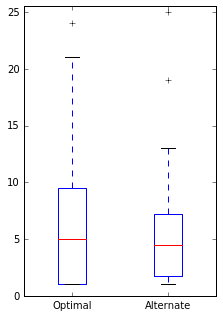

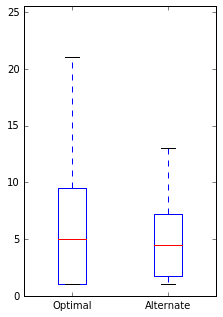

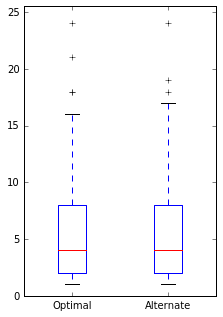

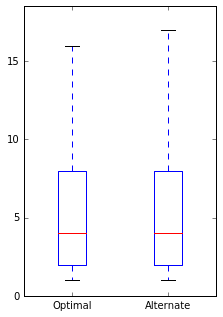

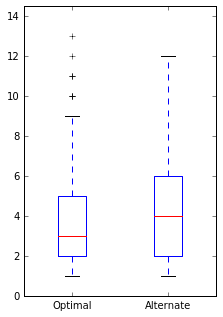

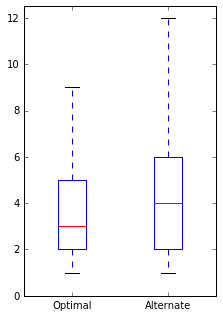

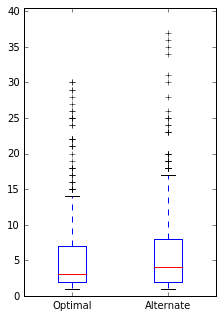

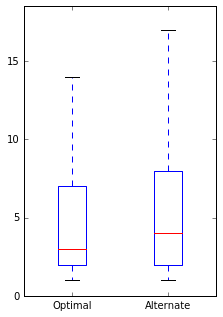

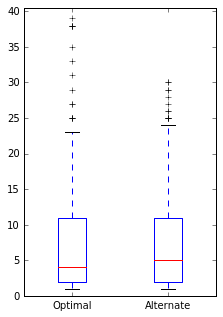

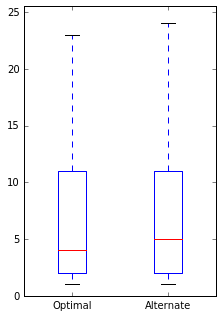

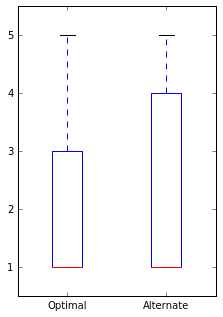

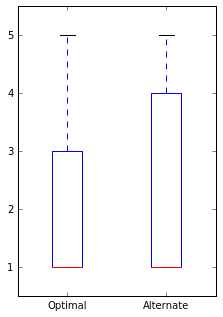

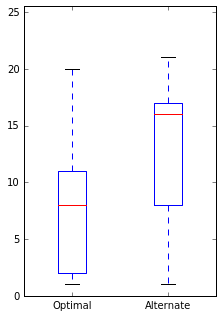

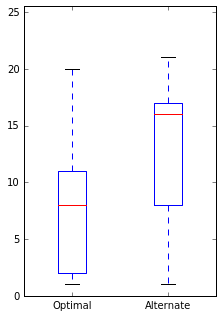

In [334]:
for project, table in best_dits['corpus'].items():
    print(project)
    print(table.sample(1))
    optimal = corpus_df[
                    (corpus_df.Task == "DIT") &
                    (corpus_df.Additions == table.Additions.values[0]) &
                    (corpus_df.Removals == table.Removals.values[0]) &
                    (corpus_df.Context == table.Context.values[0]) &
                    (corpus_df.Message == table.Message.values[0])]
    
    alt_table = best_flts['corpus'][project]
    print(alt_table.sample(1))

    alternate = corpus_df[
                          (corpus_df.Task == "DIT") &
                          (corpus_df.Additions == alt_table.Additions.values[0]) &
                          (corpus_df.Removals == alt_table.Removals.values[0]) &
                          (corpus_df.Context == alt_table.Context.values[0]) &
                          (corpus_df.Message == alt_table.Message.values[0])]
            
    if project != "all subject systems":
        optimal = optimal[optimal.Subject == project]
        alternate = alternate[alternate.Subject == project]
    
    merge_df = optimal.merge(alternate, on=["Subject", "Task", "Issue"])
    optalt_df = pandas.DataFrame()
    optalt_df["Optimal"] = merge_df.Rank_x
    optalt_df["Alternate"] = merge_df.Rank_y
    
    plot_dataframe(optalt_df, project,  "rq2", "dit")